In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import sklearn.decomposition
import sklearn.manifold
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.svm
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def KL(rho, rho_j):
    return rho * tf.log(rho / rho_j) + (1 - rho) * tf.log((1 - rho) / (1 - rho_j))

In [3]:
def svm_acc(X_train, y_train, X_test, y_test, C):
    """Trains and evaluates a linear SVM with the given data and C value."""
    clf = sklearn.svm.LinearSVC(C=C, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

(30000, 784)
1.0 0.0


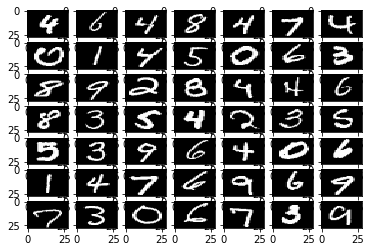

In [46]:
# images,labels_train = mnist.train.next_batch(batch_size=numpatches)
patchsize = 28
numpatches = 30000
patches = mnist.train.images[:30000, :]
labels_train = mnist.train.labels[:30000, :]
tests = mnist.test.images
labels_test = mnist.test.labels
y_train = np.sum(labels_train * np.arange(10), axis=1)
y_test = np.sum(labels_test * np.arange(10), axis=1)
print(patches.shape)
print(np.max(patches), np.min(patches))
plt.figure()
for i in range(49):
    ax= plt.subplot(7, 7,i+1)
    im=ax.imshow(patches[np.random.randint(0, numpatches), :].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')

In [43]:
def SAE(patchsize = 28, numpatches = 2500, hiddenSize = 1500, learning_rate = 0.01, epochs = 20, batch_size = 100, 
        regul_weight = 5e-4, sparsity = 0.25, sparsity_weight = 3):
    visibleSize = patchsize*patchsize
    data = tf.placeholder(tf.float32, [None, visibleSize])
    x = tf.placeholder(tf.float32, [None, visibleSize])
    y = tf.placeholder(tf.float32, [None, visibleSize])

    r  = np.sqrt(6) / np.sqrt(hiddenSize+visibleSize+1)
    W1 = tf.Variable(tf.random_uniform([visibleSize, hiddenSize], -r, r), name='W1')
    b1 = tf.Variable(tf.random_normal([hiddenSize]), name='b1')

    W2 = tf.Variable(tf.random_uniform([hiddenSize, visibleSize], -r, r), name='W2')
    b2 = tf.Variable(tf.random_normal([visibleSize]), name='b2')

    hidden_out = tf.add(tf.matmul(x, W1), b1)
    hidden_out = tf.nn.sigmoid(hidden_out)

    activation = tf.nn.sigmoid(tf.add(tf.matmul(data, W1), b1))
    rho = tf.reduce_mean(activation, 0)
    y_ = tf.nn.sigmoid(tf.add(tf.matmul(hidden_out, W2), b2))
    # y_ = tf.nn.relu(tf.add(tf.matmul(hidden_out, W2), b2))

    rho = tf.clip_by_value(rho, 1e-10, 0.9999999)
    MSE = tf.reduce_mean(1/2 * tf.square(y_ - y))
    # regul = tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(W2))
    regul = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    penalty = tf.reduce_sum(KL(sparsity, rho))
    loss = MSE + regul_weight * regul + sparsity_weight * penalty

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        for epoch in range(epochs):
            avg_cost = 0
            total_batch = int(numpatches / batch_size)
            for i in range(total_batch):
                batch_x = patches[batch_size*i:batch_size*(i+1), :]
                _, c = sess.run([optimiser, loss],
                                feed_dict={x: batch_x, y: batch_x, data: patches})
                avg_cost += c / total_batch
            print("Epoch:", (epoch + 1), "cost =", "{:.8f}".format(avg_cost))
        feed_dict = {x: patches}
        classification = sess.run(y_, feed_dict)
        X_train = sess.run(hidden_out, feed_dict)
        X_test = sess.run(hidden_out, {x: tests})
        plt.figure()
        for i in range(49):
            ax= plt.subplot(7, 7,i+1)
            im=ax.imshow(classification[i, :].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')
        weights = sess.run(W1)
        fig = plt.figure(figsize=(10, 10))
        weightsize = 7
        for i in range(weightsize*weightsize):
            ax= plt.subplot(weightsize, weightsize,i+1)
            ax.axis('off')
            im=ax.imshow(weights[:, i].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')
        fig.savefig("MNIST_2REG_"+str(sparsity)+"_"+str(sparsity_weight)+"_"+str(regul_weight)+"_"+str(epochs)+".pdf")
        return X_train, X_test

In [ ]:
C = 10
# for regu in np.logspace(-2, 1, 7):
if True:
    regu = 1e-2
    X_train, X_test = SAE(patchsize = 28, numpatches = numpatches, hiddenSize = 1500, learning_rate = 0.01, epochs = 10,
                          batch_size = 100, regul_weight = regu, sparsity = 0.1, sparsity_weight = 3)
    # for C in np.logspace(-2, 1, 4):
    acc, _ = svm_acc(X_train, y_train, X_test, y_test, C)
    print("regularization weight: ", regu, ' C={:.3f}, acc={:.4f}'.format(C, acc))

Epoch: 1 cost = 134.94529238
Epoch: 2 cost = 64.42407725
Epoch: 3 cost = 44.80438435
Epoch: 4 cost = 33.15044090


In [42]:
svm_acc(patches, y_train, tests, y_test, C)[0]

0.87260000000000004